# Neural Network Binning

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [12]:
import jax.random
import jax.numpy as jnp

In [13]:
from flax import nn, optim, serialization

Initialize fast metric calculations:

In [3]:
from zotbin.binned import *

In [4]:
init_data = load_binned('binned_40.npz')

Load the challenge data:

In [5]:
bands='riz'
include_colors=False
include_errors=False

In [6]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Preprocess the training data:

In [7]:
colors = np.diff(train_data, axis=1)

In [8]:
iband = bands.index('i')
data = np.concatenate((colors, train_data[:, iband:iband+1]), axis=1)

In [9]:
from sklearn.preprocessing import RobustScaler

In [10]:
preproc = RobustScaler()
features = preproc.fit_transform(train_data)

Load classification labels:

In [11]:
label2 = np.load('buzzard_labels2.npy')
label4 = np.load('buzzard_labels4.npy')
label8 = np.load('buzzard_labels8.npy')

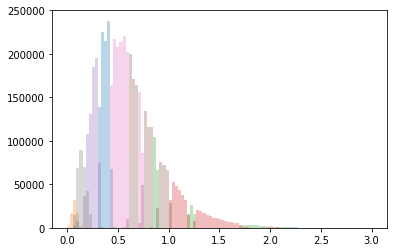

In [64]:
for i in range(8):
    plt.hist(train_z[label8 == i], bins=np.linspace(0, 3, 100), alpha=0.3)

Build a dense classifier network:

In [32]:
class Classifier(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=100, name='L1')
        x = nn.relu(x)
        x = nn.Dense(x, features=100, name='L2')
        x = nn.relu(x)
        x = nn.Dense(x, features=8, name='L3')
        x = nn.log_softmax(x)
        return x

In [42]:
@jax.vmap
def cross_entropy_loss(logits, label):
    return -logits[label]

In [58]:
@jax.jit
def train_step(optimizer, batch):
    def loss_fn(model):
        logits = model(batch['features'])
        loss = jnp.mean(cross_entropy_loss(logits, batch['labels']))
        return loss
    grad = jax.grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [65]:
@jax.jit
def eval_step(model, eval_ds):
    logits = model(eval_ds['features'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == eval_ds['labels'])
    loss = jnp.mean(cross_entropy_loss(logits, eval_ds['labels']))
    return {'loss': loss,  'accuracy': accuracy}

In [71]:
def train(data, iz, batchsize=10000, nepoch=100, seed=123):
    
    features = jnp.asarray(data)
    labels = jnp.asarray(iz, jnp.int32)
    ndata = len(features)
    nbatch = ndata // batchsize
    gen = np.random.RandomState(seed)
    
    _, initial_params = Classifier.init(jax.random.PRNGKey(0), features[:batchsize])
    model = nn.Model(Classifier, initial_params)
    print(jax.tree_map(jnp.shape, model.params))
    optimizer = optim.Momentum(learning_rate=0.001, beta=0.9).create(model)
    
    for epoch in range(nepoch):
        batch = gen.choice(ndata, nbatch * batchsize, replace=False).reshape(nbatch, batchsize)
        for i in range(nbatch):
            optimizer = train_step(optimizer, {'features': features[batch[i]], 'labels': labels[batch[i]]})
        train_eval = eval_step(optimizer.target, {'features': features, 'labels': labels})
        print(f'epoch {epoch+1}/{nepoch}: train loss={train_eval["loss"]:.6f} accuracy={train_eval["accuracy"]:.6f}')

train(data, label8)

{'L1': {'bias': (100,), 'kernel': (3, 100)}, 'L2': {'bias': (100,), 'kernel': (100, 100)}, 'L3': {'bias': (8,), 'kernel': (100, 8)}}
epoch 1/100: train loss=1.549593 accuracy=0.381428
epoch 2/100: train loss=1.410634 accuracy=0.463285
epoch 3/100: train loss=1.339616 accuracy=0.466406
epoch 4/100: train loss=1.301584 accuracy=0.475462
epoch 5/100: train loss=1.279500 accuracy=0.479665
epoch 6/100: train loss=1.280414 accuracy=0.469842
epoch 7/100: train loss=1.274264 accuracy=0.475109
epoch 8/100: train loss=1.246219 accuracy=0.481805
epoch 9/100: train loss=1.231485 accuracy=0.489400
epoch 10/100: train loss=1.229690 accuracy=0.488708
epoch 11/100: train loss=1.222467 accuracy=0.494511
epoch 12/100: train loss=1.212283 accuracy=0.499441
epoch 13/100: train loss=1.207327 accuracy=0.501725
epoch 14/100: train loss=1.214399 accuracy=0.491900
epoch 15/100: train loss=1.190291 accuracy=0.514734
epoch 16/100: train loss=1.184384 accuracy=0.512024
epoch 17/100: train loss=1.184523 accuracy=0

## Sandbox

In [37]:
ndata = 10000
features = jnp.array(features[:ndata])
labels = jnp.array(train_z[:ndata])

Define a network:

In [34]:
nbins = 4

In [24]:
class NN(nn.Module):
    def apply(self, x, nbins):
        x = nn.Dense(x, 100, name='L1')
        x = nn.relu(x)
        x = nn.Dense(x, 100, name='L2')
        x = nn.relu(x)
        x = nn.Dense(x, nbins, name='L3')
        return nn.softmax(x)

In [25]:
module = NN.partial(nbins=4)

In [26]:
_, nn_init = module.init(jax.random.PRNGKey(0), features)

In [27]:
jax.tree_map(jnp.shape, nn_init)

{'L1': {'bias': (100,), 'kernel': (4, 100)},
 'L2': {'bias': (100,), 'kernel': (100, 100)},
 'L3': {'bias': (4,), 'kernel': (100, 4)}}

In [28]:
model = nn.Model(module, nn_init)

In [29]:
jax.tree_map(jnp.shape, model.params)

{'L1': {'bias': (100,), 'kernel': (4, 100)},
 'L2': {'bias': (100,), 'kernel': (100, 100)},
 'L3': {'bias': (4,), 'kernel': (100, 4)}}

In [30]:
model(features[0])

DeviceArray([0.20889738, 0.25362805, 0.26156127, 0.27591333], dtype=float32)

In [61]:
optimizer = optim.Adam(learning_rate=0.001).create(model)

In [68]:
def train_step(optimizer, batch):
    
    def loss_fn(model):
        out = model(batch['features'])
        idx = jnp.argmax(out, axis=-1)
        print(idx)
        scores = get_binned_scores(idx, batch['z'], *init_data)
        print(scores)
        return scores['FOM_DETF_3x2']
    
    loss, g = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(g)
    return optimizer, loss

In [69]:
nbatch = 10
gen = np.random.RandomState(123)

In [70]:
def get_batch():
    idx = gen.choice(ndata, nbatch)
    return {'features': features[idx], 'z': labels[idx]}

In [71]:
def train(opt, niter=10):
    
    losses = []
    for i in range(niter):
        opt, loss = train_step(opt, get_batch())
        print(loss)
        
train(optimizer)

[3 3 3 3 3 3 2 0 3 1]
{'SNR_3x2': DeviceArray(1319.0688, dtype=float32), 'FOM_3x2': DeviceArray(2835.5964, dtype=float32), 'FOM_DETF_3x2': DeviceArray(29.425533, dtype=float32)}
29.425533
[0 3 3 3 3 0 3 3 3 3]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 2 3 3 3 3 3 3 3 3]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 2 3 3 3 3 3 3 3 2]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 2 2 2 2 3 3 3 3 3]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float32)}
nan
[3 3 3 3 2 2 3 3 3 2]
{'SNR_3x2': DeviceArray(nan, dtype=float32), 'FOM_3x2': DeviceArray(nan, dtype=float32), 'FOM_DETF_3x2': DeviceArray(nan, dtype=float3